# Check GPU

In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception:
    print('No Nvidia GPU in system!')

No Nvidia GPU in system!


# Import Libraries

In [6]:
# Load Libraries
# !pip install tensorflow_datasets
import os, datetime
import gc
from PIL import Image
import numpy as np
import pathlib
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as t
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from timeit import default_timer as timer
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

%matplotlib inline
plt.style.use('fivethirtyeight')

# Inspect the data

In [7]:
%ls final_dataset

 Volume in drive C is Windows-SSD
 Volume Serial Number is D43D-9ECF

 Directory of C:\Users\mnis9\Seal Eng Image\CV-gpu\final_dataset

05/30/2022  08:36 PM    <DIR>          .
06/24/2022  08:20 AM    <DIR>          ..
05/30/2022  08:36 PM    <DIR>          testing
05/30/2022  08:36 PM    <DIR>          training
05/30/2022  08:36 PM    <DIR>          validation
               0 File(s)              0 bytes
               5 Dir(s)  256,769,224,704 bytes free


In [8]:
# walk through seal_image_datasets directory and list numberof files
for dirpath, dirnames, filenames in os.walk("C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/'.
There are 2 directories and 0 images in 'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/testing'.
There are 0 directories and 67 images in 'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/testing\nok'.
There are 0 directories and 67 images in 'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/testing\ok'.
There are 2 directories and 0 images in 'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/training'.
There are 0 directories and 315 images in 'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/training\nok'.
There are 0 directories and 315 images in 'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/training\ok'.
There are 2 directories and 0 images in 'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/validation'.
There are 0 directories and 66 images in 'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/validation\nok'.
There are 0 directories and 66 images in 'C:/Users/mnis

In [9]:
# Get the class names
data_dir = pathlib.Path("C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/training/") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['nok' 'ok']


## View random image 

In [10]:
def view_random_image(target_dir, target_class):
    
    # Setup target directory
    target_folder = target_dir+target_class
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    print(f"Image shape: {img.shape}")
    
    return img

Image shape: (2160, 2880, 3)


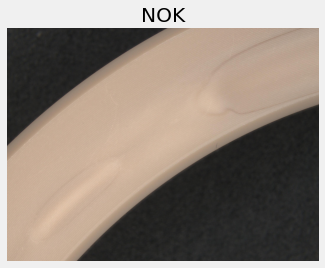

In [11]:
# View a random image from the training dataset
img = view_random_image(target_dir="final_dataset/training/",
                        target_class="NOK")

Image shape: (2860, 8162, 3)
Image shape: (2160, 2880, 3)


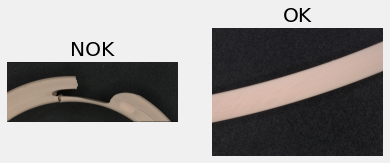

In [12]:
# Visualize data
plt.figure()
plt.subplot(1, 2, 1)
nok_img = view_random_image("final_dataset/training/", "NOK")
plt.subplot(1, 2, 2)
ok_img = view_random_image("final_dataset/training/", "OK")

In [9]:
# View the img
img

array([[[ 43,  41,  42],
        [ 41,  39,  40],
        [ 39,  37,  38],
        ...,
        [ 36,  36,  38],
        [ 33,  33,  35],
        [ 33,  33,  35]],

       [[ 45,  43,  44],
        [ 44,  42,  43],
        [ 42,  40,  41],
        ...,
        [ 35,  35,  37],
        [ 35,  35,  37],
        [ 37,  37,  39]],

       [[ 41,  39,  40],
        [ 40,  38,  39],
        [ 39,  37,  38],
        ...,
        [ 35,  35,  37],
        [ 38,  38,  40],
        [ 40,  40,  42]],

       ...,

       [[ 44,  43,  38],
        [ 40,  39,  34],
        [ 36,  35,  30],
        ...,
        [130, 113, 103],
        [128, 111, 101],
        [127, 110, 100]],

       [[ 41,  40,  35],
        [ 40,  39,  34],
        [ 38,  37,  32],
        ...,
        [135, 118, 108],
        [133, 116, 106],
        [130, 113, 103]],

       [[ 37,  36,  31],
        [ 40,  39,  34],
        [ 42,  41,  36],
        ...,
        [134, 117, 107],
        [131, 114, 104],
        [126, 109,  99]]

In [13]:
# View the image shape
img.shape # returns (width, height, colour channels)

(2160, 2880, 3)

In [14]:
# Get all the pixel values between 0 & 1
img/255. 

array([[[0.15686275, 0.16078431, 0.12941176],
        [0.18431373, 0.18823529, 0.15686275],
        [0.19607843, 0.2       , 0.16862745],
        ...,
        [0.65882353, 0.58823529, 0.53333333],
        [0.6627451 , 0.59215686, 0.5372549 ],
        [0.67058824, 0.6       , 0.54509804]],

       [[0.17254902, 0.17647059, 0.14509804],
        [0.19215686, 0.19607843, 0.16470588],
        [0.2       , 0.20392157, 0.17254902],
        ...,
        [0.6745098 , 0.60392157, 0.54901961],
        [0.6745098 , 0.60392157, 0.54901961],
        [0.67843137, 0.60784314, 0.55294118]],

       [[0.16470588, 0.16862745, 0.1372549 ],
        [0.18039216, 0.18431373, 0.15294118],
        [0.18431373, 0.18823529, 0.15686275],
        ...,
        [0.69411765, 0.62352941, 0.56862745],
        [0.69411765, 0.62352941, 0.56862745],
        [0.69019608, 0.61960784, 0.56470588]],

       ...,

       [[0.76862745, 0.6627451 , 0.58039216],
        [0.76862745, 0.6627451 , 0.58039216],
        [0.76862745, 0

### Building an Image Classification Model with CNN

## First Model
As our baseline model, we will build a simple convolutional neural network that takes in images after resizing them to be a square matrix and normalizing all pixel values to range from 0 to 1. The full step is shown below.

In [20]:
train_dir = './final_dataset/training'
test_dir = './final_dataset/testing'
val_dir = './final_dataset/validation'

EPOCHS = 100
PATIENCE = 5
INPUT_SHAPE = (256, 256, 3)
IMG_SHAPE = (256, 256)
BATCH_SIZE = 32

tf.random.set_seed(42)

model_name = '24_June_Transfer_learning_Final.h5'

train_datagen = ImageDataGenerator(rescale = 1/255.)
val_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


# initiating generator that rescale and resize the images in a directory
train_g = train_datagen.flow_from_directory(train_dir,
                                            batch_size = BATCH_SIZE,
                                            target_size = IMG_SHAPE, 
                                            color_mode ='rgb',
                                            shuffle = True,
                                            class_mode = 'binary',
                                            seed = 42)                                                                                                                                    
                                                                  
val_g = val_datagen.flow_from_directory(val_dir,
                                        batch_size = BATCH_SIZE,
                                        target_size = IMG_SHAPE, 
                                        color_mode='rgb',
                                        shuffle = True,
                                        class_mode='binary',
                                        seed = 42)

test_g = test_datagen.flow_from_directory(test_dir,
                                          batch_size = BATCH_SIZE,
                                          target_size = IMG_SHAPE, 
                                          color_mode='rgb',
                                          class_mode='binary',
                                          shuffle = False,
                                          seed = 42)

Found 630 images belonging to 2 classes.
Found 132 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


## Evaluation Metrics

Since we don't want to miss any defect or nok seals, we would prioritize the `recall score`. But our dataset is also skewed towards the positive class (more observation of nok than ok) so by chance the recall score may not capture model's performance well enough. So we will also use accuracy and aim for both high accuracy and recall.

In [21]:
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch
    
    plt.plot(epochs, hist_['accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    recall = np.array(hist_['recall'])
    precision = np.array(hist_['precision'])
    val_recall = np.array(hist_['val_recall'])
    val_precision = np.array(hist_['val_precision'])
    plt.figure()
    plt.plot(epochs, 
             2*((recall * precision)/(recall + precision)), 
             label='Training f1')
    plt.plot(epochs, 
             2*((val_recall * val_precision)/(val_recall + val_precision)), 
             label='Validation f1')
    plt.title('Training and validation F1-Score')
    plt.legend()
    
    plt.show()

## Data Augmentation 

In [23]:
# training with augmented data
data_aug_train = image.ImageDataGenerator(rescale = 1/255,
                                          rotation_range = 20,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          shear_range = 0.1,
                                          zoom_range = 0.1,
                                          brightness_range = [0.5,1.5],
                                          horizontal_flip = True )

train_g1 = data_aug_train.flow_from_directory(train_dir,
                                              batch_size = BATCH_SIZE,
                                              target_size = IMG_SHAPE, 
                                              color_mode ='rgb',
                                              shuffle = True,
                                              class_mode = 'binary'
                                              )

Found 630 images belonging to 2 classes.


In [26]:
# training with augmented data
data_aug_train = image.ImageDataGenerator(rescale = 1/255,
                                          rotation_range = 40,
                                          width_shift_range = 0.2,
                                          height_shift_range = 0.2,
                                          shear_range = 0.2,
                                          zoom_range = 0.2,
                                          brightness_range = [0.2, 0.8],
                                          horizontal_flip = True )

train_g2 = data_aug_train.flow_from_directory(train_dir,
                                              batch_size = BATCH_SIZE,
                                              target_size = IMG_SHAPE, 
                                              color_mode ='rgb',
                                              shuffle = True,
                                              class_mode = 'binary')

Found 630 images belonging to 2 classes.


## Create Model (ResNet)

In [27]:
# create model
base_model = tf.keras.applications.ResNet50V2(weights = "imagenet", include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(256, 256, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [29]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                      

In [30]:
# compile model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001, decay=1e-6),
              metrics=['accuracy', 'Recall', 'Precision'])


# make directory for logs
logdir = os.path.join('/content/gdrive/MyDrive/Image Dataset/logs', model_name)
# os.mkdir(logdir)

from math import floor
N_FOLDS = 5
INIT_LR = 3e-4
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1


# early stopping
cp = EarlyStopping(monitor ='val_loss', mode = 'min', verbose = 2, patience = PATIENCE, restore_best_weights=True)

mc = ModelCheckpoint(model_name, monitor = 'val_loss', mode = 'min', verbose = 2, save_best_only = True)

tsb = TensorBoard(log_dir=logdir)

lrs = LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step))), 

# training
start = timer()

In [31]:
# Fit the model
history = model.fit(train_g, 
                    epochs=EPOCHS, 
                    steps_per_epoch = len(train_g),
                    validation_data = val_g,
                    validation_steps = len(val_g),
                    workers = 7, 
                    callbacks= [cp, mc, tsb, lrs], 
                    verbose = 2)
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.50153, saving model to 24_June_Transfer_learning_Final.h5
20/20 - 62s - loss: 0.5993 - accuracy: 0.7032 - recall: 0.7651 - precision: 0.6808 - val_loss: 0.5015 - val_accuracy: 0.8106 - val_recall: 0.8333 - val_precision: 0.7971 - lr: 3.0000e-04 - 62s/epoch - 3s/step
Epoch 2/100

Epoch 2: val_loss improved from 0.50153 to 0.39443, saving model to 24_June_Transfer_learning_Final.h5
20/20 - 58s - loss: 0.4410 - accuracy: 0.8524 - recall: 0.8698 - precision: 0.8405 - val_loss: 0.3944 - val_accuracy: 0.8864 - val_recall: 0.9242 - val_precision: 0.8592 - lr: 2.8500e-04 - 58s/epoch - 3s/step
Epoch 3/100

Epoch 3: val_loss improved from 0.39443 to 0.33572, saving model to 24_June_Transfer_learning_Final.h5
20/20 - 57s - loss: 0.3634 - accuracy: 0.8778 - recall: 0.9143 - precision: 0.8521 - val_loss: 0.3357 - val_accuracy: 0.8939 - val_recall: 0.9242 - val_precision: 0.8714 - lr: 2.7075e-04 - 57s/epoch - 3s/step
Epoch 4/100

Epoch 4: val_los

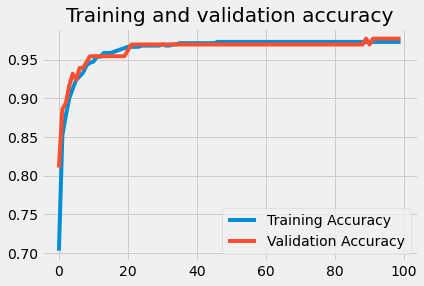

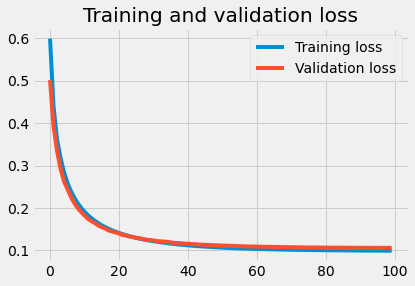

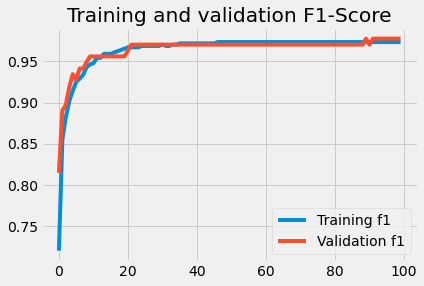

5/5 - 10s - loss: 0.1059 - accuracy: 0.9773 - recall: 0.9848 - precision: 0.9701 - 10s/epoch - 2s/step


[0.10593488067388535,
 0.9772727489471436,
 0.9848484992980957,
 0.9701492786407471]

In [32]:
plot_performance(history)
model.evaluate(val_g, workers = 8, verbose = 2)

In [33]:
model.save('MODEL/24_June_ResNet_Transfer_learning_ResNet_Final.h5')

# ResNet with Fine Tuning

In [34]:
# create model
base_model = tf.keras.applications.ResNet50V2(weights = "imagenet", include_top=False)
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
    
inputs = tf.keras.layers.Input(shape=(256, 256, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [35]:
# compile model
model_1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001, decay=1e-6),
              metrics=['accuracy', 'Recall', 'Precision'])

In [36]:
# Fit the model
history_1 = model.fit(train_g, 
                    epochs=100, 
                    steps_per_epoch=len(train_g),
                    validation_data = val_g,
                    validation_steps=len(val_g), 
                    workers = 7, 
                    callbacks= [cp, mc, tsb, lrs], 
                    verbose = 2)
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100

Epoch 1: val_loss improved from 0.10593 to 0.10219, saving model to 24_June_Transfer_learning_Final.h5
20/20 - 59s - loss: 0.0980 - accuracy: 0.9746 - recall: 0.9841 - precision: 0.9657 - val_loss: 0.1022 - val_accuracy: 0.9773 - val_recall: 0.9848 - val_precision: 0.9701 - lr: 3.0000e-04 - 59s/epoch - 3s/step
Epoch 2/100

Epoch 2: val_loss improved from 0.10219 to 0.09784, saving model to 24_June_Transfer_learning_Final.h5
20/20 - 59s - loss: 0.0930 - accuracy: 0.9730 - recall: 0.9841 - precision: 0.9627 - val_loss: 0.0978 - val_accuracy: 0.9773 - val_recall: 0.9848 - val_precision: 0.9701 - lr: 2.8500e-04 - 59s/epoch - 3s/step
Epoch 3/100

Epoch 3: val_loss improved from 0.09784 to 0.09508, saving model to 24_June_Transfer_learning_Final.h5
20/20 - 59s - loss: 0.0888 - accuracy: 0.9762 - recall: 0.9841 - precision: 0.9688 - val_loss: 0.0951 - val_accuracy: 0.9773 - val_recall: 0.9848 - val_precision: 0.9701 - lr: 2.7075e-04 - 59s/epoch - 3s/step
Epoch 4/100

Epoch 4: val

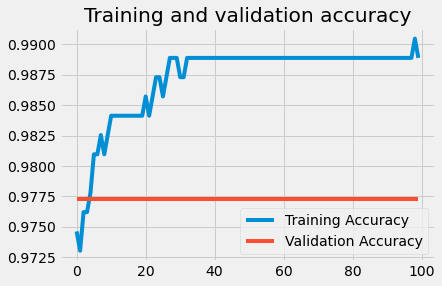

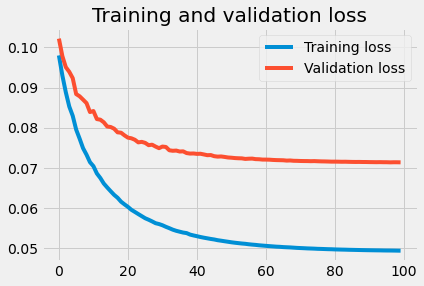

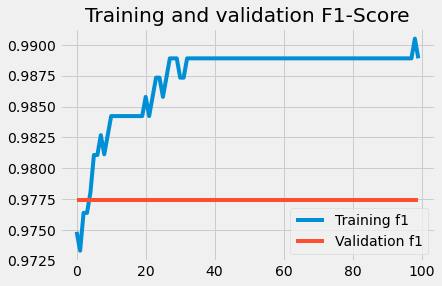

5/5 - 12s - loss: 0.6571 - accuracy: 0.6136 - recall: 0.7273 - precision: 0.5926 - 12s/epoch - 2s/step


[0.6570827960968018,
 0.6136363744735718,
 0.7272727489471436,
 0.5925925970077515]

In [37]:
plot_performance(history_1)
model_1.evaluate(val_g, workers = 8, verbose = 2)

In [38]:
model.save('MODEL/24_June_ResNet_Transfer_learning_ResNet_Final_1.h5')

## Review

In [39]:
model_final = models.load_model('MODEL/24_June_ResNet_Transfer_learning_ResNet_Final_1.h5')

In [40]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [41]:
model_final.evaluate(test_g, verbose = 2, workers = 8)

5/5 - 11s - loss: 0.0678 - accuracy: 0.9701 - recall: 0.9851 - precision: 0.9565 - 11s/epoch - 2s/step


[0.06779847294092178, 0.9701492786407471, 0.9850746393203735, 0.95652174949646]

## Making an Prediction with the trained model


In [42]:
# Classes we're working with
print(class_names)

['nok' 'ok']


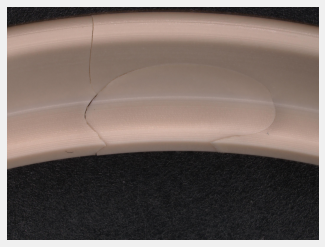

In [43]:
# View our example image
ok_image = mpimg.imread(r"C:\Users\mnis9\Seal Eng Image\CV-gpu\All images\Image888.jpg")
plt.imshow(ok_image)
plt.axis(False);

# "C:\Users\mnis9\Seal Eng Image\CV-gpu\All images\Image888.jpg"

In [44]:
# Check the shape of our image
ok_image.shape

(2160, 2880, 3)

In [45]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=256):
    
    # Read in target file (an image)
    img = tf.io.read_file(filename)
    
    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)
    
    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])
    
    # Rescale the image (get all values between 0 and 1)
    
    img = img/255.
    return img

In [46]:
# Load in and preprocess our custom image
nok_image = load_and_prep_image("C:/Users/mnis9/Seal Eng Image/CV-gpu/All images/Image888.jpg")
nok_image

# "C:\Users\mnis9\Seal Eng Image\CV-gpu\final_dataset\training\nok\NOK_FL_0.jpg"
# r"C:\Users\mnis9\Seal Eng Image\CV-gpu\All images\Image888.jpg

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.0894761 , 0.0894761 , 0.08163296],
        [0.06107537, 0.06107537, 0.0689185 ],
        [0.05142463, 0.05142463, 0.05926777],
        ...,
        [0.06763174, 0.06763174, 0.06542586],
        [0.06490503, 0.0616728 , 0.0802696 ],
        [0.17585784, 0.18590686, 0.18419118]],

       [[0.14880514, 0.15272671, 0.1286152 ],
        [0.07244179, 0.06999081, 0.08518688],
        [0.07542892, 0.07542892, 0.08327206],
        ...,
        [0.20062806, 0.20101103, 0.192019  ],
        [0.18429841, 0.18305759, 0.19385724],
        [0.10079657, 0.09295343, 0.10471813]],

       [[0.0743413 , 0.0743413 , 0.07532169],
        [0.08259804, 0.08259804, 0.0747549 ],
        [0.24255514, 0.24255514, 0.24549632],
        ...,
        [0.08414522, 0.08414522, 0.08414522],
        [0.05868566, 0.05868566, 0.05868566],
        [0.04575674, 0.04575674, 0.05359988]],

       ...,

       [[0.12314644, 0.11922488, 0.11138174],
        [0.22

In [47]:
# Add an extra axis
print(f"Shape before new dimension: {nok_image.shape}")
nok_image = tf.expand_dims(nok_image, axis=0) # add an extra dimension at axis 0
print(f"Shape after new dimension: {nok_image.shape}")
nok_image

Shape before new dimension: (256, 256, 3)
Shape after new dimension: (1, 256, 256, 3)


<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[0.0894761 , 0.0894761 , 0.08163296],
         [0.06107537, 0.06107537, 0.0689185 ],
         [0.05142463, 0.05142463, 0.05926777],
         ...,
         [0.06763174, 0.06763174, 0.06542586],
         [0.06490503, 0.0616728 , 0.0802696 ],
         [0.17585784, 0.18590686, 0.18419118]],

        [[0.14880514, 0.15272671, 0.1286152 ],
         [0.07244179, 0.06999081, 0.08518688],
         [0.07542892, 0.07542892, 0.08327206],
         ...,
         [0.20062806, 0.20101103, 0.192019  ],
         [0.18429841, 0.18305759, 0.19385724],
         [0.10079657, 0.09295343, 0.10471813]],

        [[0.0743413 , 0.0743413 , 0.07532169],
         [0.08259804, 0.08259804, 0.0747549 ],
         [0.24255514, 0.24255514, 0.24549632],
         ...,
         [0.08414522, 0.08414522, 0.08414522],
         [0.05868566, 0.05868566, 0.05868566],
         [0.04575674, 0.04575674, 0.05359988]],

        ...,

        [[0.12314644, 0.11922488, 

In [48]:
# Make a prediction on custom image tensor
pred = model.predict(nok_image)
pred

1/1 [==============================] - 1s 1s/step


array([[0.00014638]], dtype=float32)

In [49]:
# our class names
class_names

array(['nok', 'ok'], dtype='<U3')

In [50]:
# index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'nok'

In [51]:
def pred_and_plot(model, filename, class_names):
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    # Get the predicted class
    pred_class = class_names[int(tf.round(pred)[0][0])]
    
    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

In [52]:
# Index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'nok'

1/1 [==============================] - 1s 1s/step


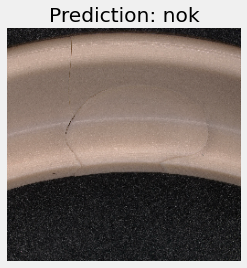

In [53]:
# Test our model on a custom image
pred_and_plot(model_final, r"C:\Users\mnis9\Seal Eng Image\CV-gpu\All images\Image888.jpg", class_names)

# "C:\Users\mnis9\Seal Eng Image\CV-gpu\All images\Image94.jpg"

1/1 [==============================] - 0s 88ms/step


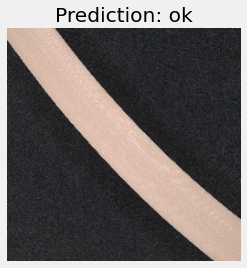

In [54]:
# Download another test image and make a prediction on it
pred_and_plot(model_final, r"C:\Users\mnis9\Seal Eng Image\CV-gpu\All images\Image580.jpg", class_names)

## Evaluation

Using a model with 94% accuracy, we'll take a look at where our model failed.


In [55]:
test_g0 = image.ImageDataGenerator(rescale = 1/255)

def get_pred(path):
    filelist = os.listdir(path)
    result = {}

    for fn in filelist:
        image_ = image.load_img(f'{path}/{fn}', 
                                target_size = (256, 256), 
                                color_mode='rgb')
        input_ = np.array([image.img_to_array(image_)])
        input_f = test_g0.flow(input_)
        result[fn] = int(np.where(model.predict(input_f)[0] > 0.5, 1, 0))
    return result

In [56]:
# C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/training
Neg_class_preds = get_pred('C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/testing/nok')
Pos_class_preds = get_pred('C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/testing/ok')

1/1 [==============================] - 0s 79ms/step


In [57]:
FP_list = [k for k, v in Neg_class_preds.items() if v != 0]
FN_list = [k for k, v in Pos_class_preds.items() if v != 1]

# Confusion Matrix

In [58]:
# getting numbers for confusion matrix
FP = len(FP_list)
FN = len(FN_list)
TP = len(Pos_class_preds) - FP
TN = len(Neg_class_preds) - FN

In [59]:
TP, FN, FP, TN

(64, 1, 3, 66)

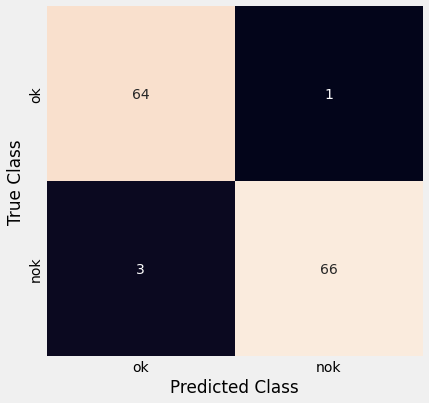

In [60]:
import seaborn as sns
cm = [[TP, FN], [FP, TN]]
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar = False, xticklabels=['ok', 'nok'], yticklabels = ['ok', 'nok'])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Sample Wrong Predictions

In [61]:
def plot_img(path, title):
    fn = image.load_img(path, color_mode='rgb')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(title)
    plt.axis('off')
    plt.show()

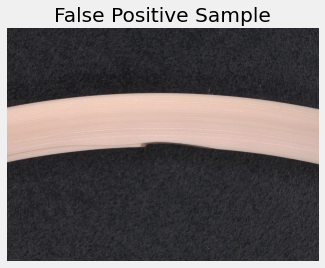

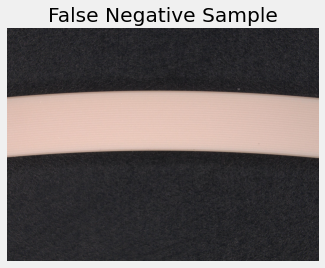

In [62]:
plot_img(f'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/testing/nok/{np.random.choice(FP_list, 1)[0]}', 'False Positive Sample')
plot_img(f'C:/Users/mnis9/Seal Eng Image/CV-gpu/final_dataset/testing/ok/{np.random.choice(FN_list, 1)[0]}', 'False Negative Sample')